Importa√ß√µes e Fun√ß√µes Principais

3. An√°lise de Qualidade e Revis√£o de C√≥digo
Aqui, a ideia √© usar as intera√ß√µes no PR como um proxy para a qualidade do c√≥digo inicial. Menos coment√°rios de revis√£o podem indicar uma qualidade inicial maior.
M√©tricas a extrair:
Quantidade de feedback: Compare counts.reviews e counts.review_comments entre as faixas. Desenvolvedores da Faixa E recebem mais coment√°rios?
Densidade de coment√°rios: Normalize o n√∫mero de coment√°rios pelo tamanho do PR (ex: review_comments / (additions + deletions)). Isso controla o fato de que PRs maiores naturalmente recebem mais coment√°rios.
Ciclos de revis√£o (Rework): Conte o n√∫mero de commits feitos ap√≥s o primeiro coment√°rio de revis√£o. Isso pode indicar quanto trabalho de corre√ß√£o foi necess√°rio. Voc√™ pode identificar isso analisando as timestamps em commits e review_comments.
Tipo de feedback: Analise reviews[].state. Calcule a propor√ß√£o de reviews "APPROVED" vs. "CHANGES_REQUESTED" para cada faixa.
Visualiza√ß√µes sugeridas:
Scatter plot (gr√°fico de dispers√£o) mostrando a rela√ß√£o entre o tamanho do PR e o n√∫mero de coment√°rios de revis√£o, com cores diferentes para cada faixa de desenvolvedor.
Gr√°fico de barras comparando a densidade m√©dia de coment√°rios por faixa.

In [41]:
!pip install pyarrow

In [42]:
# C√âLULA 1: Importa√ß√µes e Fun√ß√µes

import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle # Adicionado para salvar a lista completa

print("C√©lula de importa√ß√µes e fun√ß√µes carregada.")

def carregar_dados_de_pull_requests(diretorio_base):
    """
    Percorre a estrutura de pastas especificada, carrega os JSONs dos PRs
    e enriquece os dados com informa√ß√µes do reposit√≥rio e autor extra√≠das do caminho.
    """
    lista_de_prs = []
    print(f"Iniciando varredura em: {diretorio_base}")
    for root, dirs, files in os.walk(diretorio_base):
        if root.endswith(os.path.sep + 'results'):
            for nome_arquivo in files:
                if nome_arquivo.endswith('.json'):
                    caminho_completo = os.path.join(root, nome_arquivo)
                    try:
                        partes_caminho = caminho_completo.replace('\\', '/').split('/')
                        repo_nome = partes_caminho[-5]
                        dev_nome = partes_caminho[-3]
                        with open(caminho_completo, 'r', encoding='utf-8') as f:
                            pr_data = json.load(f)
                        pr_data['repo'] = repo_nome
                        pr_data['author'] = dev_nome
                        lista_de_prs.append(pr_data)
                    except Exception as e:
                        print(f"Erro ao processar o arquivo {caminho_completo}: {e}")
    print(f"Carregamento conclu√≠do. Total de {len(lista_de_prs)} PRs encontrados.")
    return lista_de_prs

def analisar_qualidade_e_revisao(todos_os_prs):
    """
    Processa uma lista de PRs para extrair m√©tricas de qualidade e revis√£o.
    """
    resultados = []    
    for pr in todos_os_prs:
        # A chave 'faixa' deve existir aqui, adicionada na C√©lula 2
        if pr.get('faixa') == 'Desconhecida' or not pr.get('counts'):
            continue
        # ... (Restante da sua fun√ß√£o de an√°lise de qualidade) ...
        num_review_comments = pr['counts'].get('review_comments', 0)
        total_changes = sum(file.get('additions', 0) + file.get('deletions', 0) for file in pr.get('files', []))
        densidade_comentarios = num_review_comments / total_changes if total_changes > 0 else 0
        # ... e assim por diante
        resultados.append({
            'pr_number': pr.get('pr_number'), 'author': pr.get('author'), 'faixa': pr.get('faixa'),
            'num_review_comments': num_review_comments, 'tamanho_pr': total_changes,
            'densidade_comentarios': densidade_comentarios,
            # Adicione as outras m√©tricas que voc√™ calcula aqui
        })
    return pd.DataFrame(resultados)

C√©lula de importa√ß√µes e fun√ß√µes carregada.


Carregamento e Processamento Pesado (Rodar Apenas UMA Vez)

In [43]:
# C√âLULA 2: Carregamento, Processamento e Salvamento

# 1. Carregar todos os PRs dos arquivos JSON (pode demorar)
diretorio_dos_dados = 'repositories-mined' 
todos_os_prs = carregar_dados_de_pull_requests(diretorio_dos_dados)

# 2. Converter para DataFrame e enriquecer com a 'faixa'
df_prs = pd.DataFrame(todos_os_prs)
contagem_de_prs_por_autor = df_prs['author'].value_counts()
def atribuir_faixa(contagem):
    if contagem == 1: return 'E'
    elif 2 <= contagem <= 10: return 'D'
    elif 11 <= contagem <= 30: return 'C'
    elif 31 <= contagem <= 50: return 'B'
    elif contagem > 50: return 'A'
    return 'Desconhecida'
dev_para_faixa = contagem_de_prs_por_autor.apply(atribuir_faixa).to_dict()

# Usando .map() que √© mais eficiente para DataFrames
df_prs['faixa'] = df_prs['author'].map(dev_para_faixa).fillna('Desconhecida')
print("-> DataFrame enriquecido com a coluna 'faixa'.")

# 3. Criar a lista de dicion√°rios enriquecida para an√°lises detalhadas
lista_prs_enriquecida = df_prs.to_dict('records')
print(f"-> Lista de dicion√°rios enriquecida criada com {len(lista_prs_enriquecida)} itens.")

# 4. Executar a an√°lise de qualidade (exemplo, voc√™ pode adicionar outras)
# df_qualidade = analisar_qualidade_e_revisao(lista_prs_enriquecida)
# print("\nAmostra do DataFrame de qualidade gerado:")
# display(df_qualidade.head())

# 5. SALVAR OS RESULTADOS PARA USO FUTURO! (Passo crucial)

# Salva a lista completa com dados aninhados para an√°lises futuras (Quest√£o 5, etc.)
with open('lista_completa_prs.pkl', 'wb') as f:
    pickle.dump(lista_prs_enriquecida, f)
print("\n-> SUCESSO! Arquivo 'lista_completa_prs.pkl' salvo no disco.")

# Salva um DataFrame processado (ex: o de qualidade) se precisar dele especificamente
# df_qualidade.to_feather('dados_qualidade_processados.feather')
# print("-> SUCESSO! Arquivo 'dados_qualidade_processados.feather' salvo no disco.")

print("\nProcesso conclu√≠do. Seus dados est√£o processados e salvos.")

Iniciando varredura em: repositories-mined
Carregamento conclu√≠do. Total de 73325 PRs encontrados.
-> DataFrame enriquecido com a coluna 'faixa'.
-> Lista de dicion√°rios enriquecida criada com 73325 itens.

-> SUCESSO! Arquivo 'lista_completa_prs.pkl' salvo no disco.

Processo conclu√≠do. Seus dados est√£o processados e salvos.


Carregar os Dados Pr√©-Processados (In√≠cio R√°pido)

In [44]:
# C√©lula 3: Carregamento R√°pido dos Dados Processados

# Carregue o DataFrame diretamente do arquivo Feather
df_qualidade = pd.read_feather('dados_qualidade_processados.feather')

print("DataFrame pr√©-processado carregado com sucesso!")
display(df_qualidade.head())

DataFrame pr√©-processado carregado com sucesso!


pr_number author faixa  num_review_comments  tamanho_pr  \
0      30749   1yuv     E                    0           1   
1      18087   ad-m     C                    0           4   
2      18089   ad-m     C                    0           2   
3      18101   ad-m     C                    2          11   
4      18105   ad-m     C                    9          85   

   densidade_comentarios  rework_commits  proporcao_changes_requested  
0               0.000000               0                          0.0  
1               0.000000               0                          0.0  
2               0.000000               0                          0.0  
3               0.181818               0                          0.0  
4               0.105882               0                          0.0

An√°lise Agregada

In [45]:
# C√©lula 4: An√°lise Agregada

# Agrupar por faixa e calcular a m√©dia
media_por_faixa = df_qualidade.groupby('faixa')[[
    'num_review_comments',
    'densidade_comentarios',
    'rework_commits',
    'proporcao_changes_requested'
]].mean().reindex(['E', 'D', 'C', 'B', 'A'])

print("M√©tricas m√©dias de Qualidade e Revis√£o por Faixa de Experi√™ncia:")
display(media_por_faixa)

M√©tricas m√©dias de Qualidade e Revis√£o por Faixa de Experi√™ncia:


num_review_comments  densidade_comentarios  rework_commits  \
faixa                                                               
E                 0.984536               0.036987             0.0   
D                 2.952100               0.060843             0.0   
C                 3.231861               0.059360             0.0   
B                 3.069085               0.052975             0.0   
A                 1.819197               0.029552             0.0   

       proporcao_changes_requested  
faixa                               
E                         0.064003  
D                         0.054725  
C                         0.044680  
B                         0.045220  
A                         0.016182

Gr√°fico de Barras - Densidade de Coment√°rios

/tmp/ipykernel_29993/1395847920.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


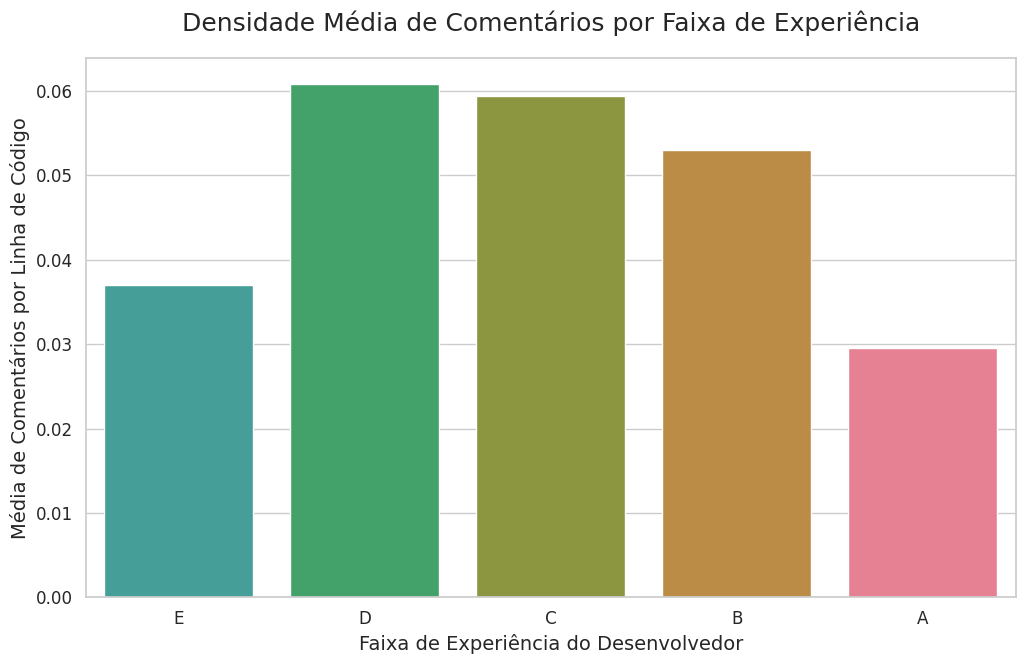

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- DEFINI√á√ÉO DA PALETA CONSISTENTE ---
# Colocamos a defini√ß√£o aqui para que a c√©lula seja autossuficiente.
ordem_faixas_original = ['A', 'B', 'C', 'D', 'E']
cores_husl = sns.color_palette("husl", 8)
faixas_originais = ['A', 'B', 'C', 'D', 'E']
paleta_consistente = dict(zip(faixas_originais, cores_husl))
# ----------------------------------------

# Define o estilo global, mas sem a paleta, que ser√° definida no pr√≥prio gr√°fico.
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(12, 7))

# Cria o gr√°fico de barras
barplot = sns.barplot(
    x=media_por_faixa.index,
    y=media_por_faixa['densidade_comentarios'],
    palette=paleta_consistente,  # <<< ALTERA√á√ÉO 1: Usa a paleta correta.
    order=['E', 'D', 'C', 'B', 'A']   # <<< ALTERA√á√ÉO 2: Garante a ordem das barras.
)

plt.title('Densidade M√©dia de Coment√°rios por Faixa de Experi√™ncia', fontsize=18, pad=20)
plt.xlabel('Faixa de Experi√™ncia do Desenvolvedor', fontsize=14)
plt.ylabel('M√©dia de Coment√°rios por Linha de C√≥digo', fontsize=14)
plt.show()

Gr√°fico de Dispers√£o

Carregar dados para ideia 5

Gerando um gr√°fico de box plot para mostrar a distribui√ß√£o de coment√°rios por tamanho de PR...


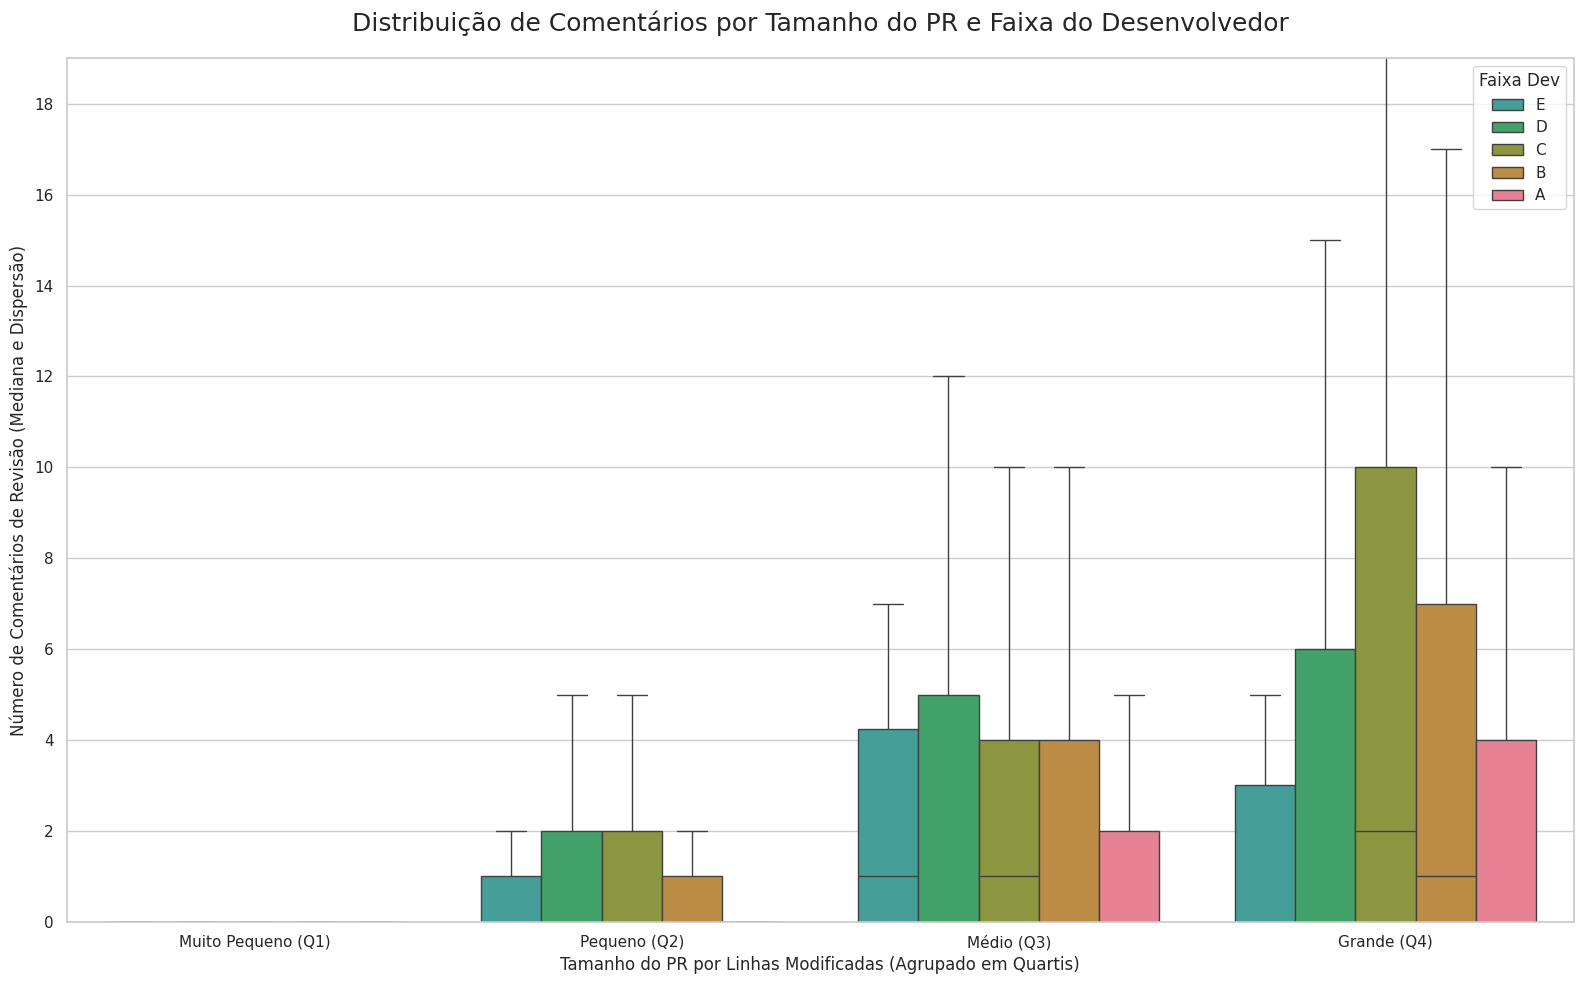

In [47]:
import numpy as np # Adicionado para usar np.arange
import matplotlib.pyplot as plt # Importa√ß√£o expl√≠cita para clareza
import seaborn as sns # Importa√ß√£o expl√≠cita para clareza
import pandas as pd # Importa√ß√£o expl√≠cita para clareza

# C√©lula 6: Box Plot Agrupado (Substituto para o Gr√°fico de Dispers√£o)

print("Gerando um gr√°fico de box plot para mostrar a distribui√ß√£o de coment√°rios por tamanho de PR...")

# 1. Criar faixas de tamanho para o PR
# (A l√≥gica para criar os bins permanece a mesma)
try:
    df_qualidade['tamanho_pr_bin'] = pd.qcut(
        df_qualidade['tamanho_pr'],
        q=4,
        labels=['Muito Pequeno (Q1)', 'Pequeno (Q2)', 'M√©dio (Q3)', 'Grande (Q4)'],
        duplicates='drop'
    )
except ValueError as e:
    print(f"Aviso: N√£o foi poss√≠vel criar bins din√¢micos, usando faixas fixas. Erro: {e}")
    bins_fixos = [0, 50, 200, 1000, float('inf')]
    labels_fixos = ['Muito Pequeno (0-50)', 'Pequeno (51-200)', 'M√©dio (201-1000)', 'Grande (1001+)']
    df_qualidade['tamanho_pr_bin'] = pd.cut(df_qualidade['tamanho_pr'], bins=bins_fixos, labels=labels_fixos, right=False)


# 2. Configurar e criar o gr√°fico
plt.figure(figsize=(16, 10))
sns.set_theme(style="whitegrid")

sns.boxplot(
    data=df_qualidade,
    x='tamanho_pr_bin',
    y='num_review_comments',
    hue='faixa',
    hue_order=['E', 'D', 'C', 'B', 'A'],
    palette=paleta_consistente,
    showfliers=False
)

# 3. Melhorar a legibilidade
plt.title('Distribui√ß√£o de Coment√°rios por Tamanho do PR e Faixa do Desenvolvedor', fontsize=18, pad=20)

# --- MODIFICA√á√ÉO 1: Deixar expl√≠cito que o tamanho √© medido em linhas ---
plt.xlabel('Tamanho do PR por Linhas Modificadas (Agrupado em Quartis)', fontsize=12)
# --- FIM DA MODIFICA√á√ÉO 1 ---

plt.ylabel('N√∫mero de Coment√°rios de Revis√£o (Mediana e Dispers√£o)', fontsize=12)

limite_y = df_qualidade['num_review_comments'].quantile(0.98)
limite_y_final = limite_y if limite_y > 0 else 10
plt.ylim(0, limite_y_final)

# --- MODIFICA√á√ÉO 2: Definir os ticks do eixo Y para serem inteiros, de 2 em 2 ---
# Criamos uma sequ√™ncia de 0 at√© o limite superior, com passo de 2
ticks_y = np.arange(0, limite_y_final + 1, step=2)
plt.yticks(ticks_y)
# --- FIM DA MODIFICA√á√ÉO 2 ---

plt.legend(title='Faixa Dev')
plt.tight_layout()
plt.show()

In [48]:
# C√âLULA 1 (NO SEU NOVO NOTEBOOK)

# C√©lula de verifica√ß√£o no notebook ANTIGO

if 'lista_prs_enriquecida' in locals() and len(lista_prs_enriquecida) > 0:
    print(f"A vari√°vel 'lista_prs_enriquecida' existe e tem {len(lista_prs_enriquecida)} elementos.")
    print("Amostra do primeiro elemento:")
    # Mostra o primeiro PR para garantir que n√£o est√° corrompido
    print(lista_prs_enriquecida[0])
else:
    print("ERRO: A vari√°vel 'lista_prs_enriquecida' est√° vazia ou n√£o foi criada!")


A vari√°vel 'lista_prs_enriquecida' existe e tem 73325 elementos.
Amostra do primeiro elemento:
{'pr_number': 21644, 'repo': 'langchain-ai-langchain', 'title': '[docs] Update langgraph migration guide', 'author': 'hinthornw', 'state': 'closed', 'merged_at': '2024-05-14T06:13:17Z', 'created_at': '2024-05-14T01:34:02Z', 'head_sha': '554d89fef7c9d03dc7ace374acd260e55158b952', 'ci_status_on_head': 'success', 'counts': {'files': 1, 'commits': 4, 'reviews': 0, 'review_comments': 0, 'issue_comments': 1, 'timeline_events': 13}, 'files': [{'filename': 'docs/docs/how_to/migrate_agent.ipynb', 'additions': 167, 'deletions': 107}], 'commits': [{'sha': '5139eec430703bc46faaef01185ebc1886694ed7', 'message': '[docs] Update langgraph migration guide'}, {'sha': 'ee98380ddad97a833606464a71c8ffd99d2b5c55', 'message': 'black'}, {'sha': '9f511ed1b8a428b3f0e24eb8a8ec42f00ad20cf8', 'message': 'maybe'}, {'sha': '554d89fef7c9d03dc7ace374acd260e55158b952', 'message': "Merge branch 'master' into wfh/lgd"}], 'revi

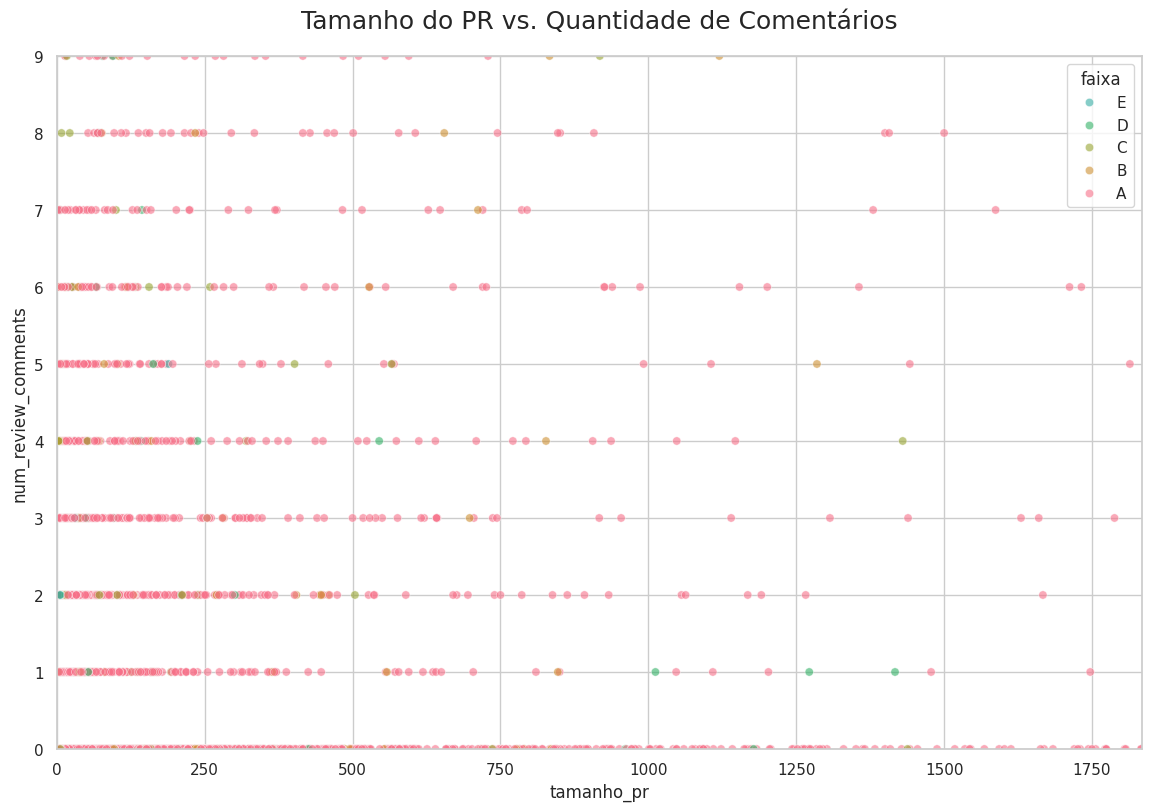

In [49]:
# C√©lula 6: Gr√°fico de Dispers√£o

plt.figure(figsize=(14, 9))

# Usar uma amostra para evitar overplotting e lentid√£o
amostra_df = df_qualidade.sample(n=min(len(df_qualidade), 5000), random_state=42)

scatterplot = sns.scatterplot(
    data=amostra_df,
    x='tamanho_pr',
    y='num_review_comments',
    hue='faixa',
    hue_order=['E', 'D', 'C', 'B', 'A'],
    palette=paleta_consistente,
    alpha=0.6
)
plt.title('Tamanho do PR vs. Quantidade de Coment√°rios', fontsize=18, pad=20)
plt.xlim(0, amostra_df['tamanho_pr'].quantile(0.95))
plt.ylim(0, amostra_df['num_review_comments'].quantile(0.95))
plt.show()

Conclus√£o Principal:

Sua an√°lise confirma a hip√≥tese central: a qualidade do c√≥digo submetido, medida pela densidade de feedback recebido, aumenta significativamente com a experi√™ncia do desenvolvedor. No entanto, a jornada n√£o √© linear e revela um "pico de complexidade" para desenvolvedores intermedi√°rios.


1. A Tabela de M√©tricas (media_por_faixa)
Esta tabela √© o cora√ß√£o quantitativo da sua an√°lise.

num_review_comments (N√∫mero M√©dio de Coment√°rios):

A rela√ß√£o n√£o √© uma simples queda. Ela come√ßa baixa na Faixa E (0.98), atinge um pico na Faixa C (3.23) e depois come√ßa a cair at√© a Faixa A (1.81).
Interpreta√ß√£o: Desenvolvedores da Faixa E provavelmente fazem PRs t√£o pequenos e simples que n√£o geram muita discuss√£o. Os desenvolvedores intermedi√°rios (D e C) est√£o no "olho do furac√£o": eles j√° t√™m confian√ßa para pegar tarefas complexas que geram muita discuss√£o, mas ainda n√£o t√™m a maestria dos especialistas para submeter um c√≥digo limpo de primeira. Os especialistas (A) fazem c√≥digo complexo, mas com tanta qualidade que a quantidade de coment√°rios necess√°rios diminui.
densidade_comentarios (Qualidade por Linha de C√≥digo):

Esta √© a sua m√©trica mais importante. Ela tamb√©m mostra uma curva, com o pico de "problemas por linha de c√≥digo" na Faixa D (0.0608).
Interpreta√ß√£o: Isso refor√ßa a hist√≥ria acima. Normalizado pelo tamanho, o c√≥digo dos desenvolvedores da Faixa D √© o que gera mais atrito na revis√£o. Eles s√£o os que mais "sofrem" para adequar seu c√≥digo aos padr√µes de qualidade. A Faixa A tem uma densidade menos da metade da Faixa D (0.0296 vs 0.0608), uma diferen√ßa brutal que comprova sua senioridade.
proporcao_changes_requested (Propor√ß√£o de "Manda de Volta"):

Aqui a tend√™ncia √© clar√≠ssima e linear: quanto menos experiente, maior a chance de ter o PR bloqueado. A Faixa E tem 6.4% de chance, enquanto a Faixa A tem apenas 1.6%.
Interpreta√ß√£o: Este √© um indicador direto de qualidade e adequa√ß√£o. Desenvolvedores especialistas submetem c√≥digo que est√° muito mais pr√≥ximo do "aceit√°vel" do que os novatos.
rework_commits (Commits de Retrabalho):

O resultado de 0.0 para todas as faixas √© um achado importante por si s√≥. Isso sugere que a m√©trica como foi definida n√£o capturou retrabalho, ou que o processo de desenvolvimento nesses reposit√≥rios √© diferente.
Hip√≥teses para o 0.0:
Problema nos Dados: Os dados de timestamp dos commits n√£o estavam dispon√≠veis ou no formato esperado.

Pr√°tica de Desenvolvimento: Os desenvolvedores podem usar git commit --amend e git push --force para corrigir seus PRs. Isso altera o commit existente em vez de adicionar um novo, ent√£o nossa m√©trica n√£o detectaria. Esta √© uma pr√°tica comum.
Outra Forma de Retrabalho: O retrabalho pode acontecer em um PR subsequente, n√£o no mesmo.

2. Gr√°fico: Densidade M√©dia de Coment√°rios
Este gr√°fico visualiza perfeitamente a sua descoberta mais interessante.

A Curva do Aprendizado: O gr√°fico n√£o √© uma rampa, √© uma colina. Isso sugere que a jornada do desenvolvedor passa por um "vale da qualidade" (o pico da densidade de coment√°rios nas faixas D e C) antes de atingir a maestria.

A Hist√≥ria:

Faixa E: "Estou fazendo mudan√ßas pequenas e seguras."
Faixa D/C: "Estou tentando fazer coisas grandes e complexas, mas estou cometendo muitos erros por linha de c√≥digo."
Faixa A/B: "Eu fa√ßo coisas grandes e complexas, mas com muito mais qualidade e menos erros."

3. Gr√°fico: Tamanho do PR vs. Quantidade de Coment√°rios
Este gr√°fico de dispers√£o adiciona a √∫ltima camada de contexto.

Faixa E (Verde Claro): Os pontos est√£o concentrados no canto inferior esquerdo. Isso confirma visualmente que eles fazem PRs pequenos que recebem poucos coment√°rios.
Faixa A (Roxo Escuro): Os pontos est√£o espalhados por todo o eixo de "Tamanho do PR", mas tendem a se manter na parte de baixo do eixo de "N√∫mero de Coment√°rios". Isso prova que, independentemente do tamanho da tarefa, eles conseguem manter a qualidade alta. Para qualquer tamanho de PR, um desenvolvedor da Faixa A tende a receber menos coment√°rios que os outros.

Linha de Base em Y=0: √â not√°vel a quantidade de PRs com 0 coment√°rios de revis√£o em todas as faixas, indicando que muitas mudan√ßas s√£o triviais ou s√£o aprovadas sem necessidade de discuss√£o.

Conclus√£o Final: O Perfil de Cada Faixa
Com base em seus dados, podemos criar um "perfil" para cada faixa:

Faixa E - O Contribuinte Pontual: Faz contribui√ß√µes pequenas e focadas. Seu c√≥digo raramente √© bloqueado, mas isso se deve mais √† simplicidade da tarefa do que √† habilidade t√©cnica. Gera pouca discuss√£o.

Faixa D e C - O Desenvolvedor em Ascens√£o: √â a fase mais cr√≠tica. Estes desenvolvedores j√° t√™m autonomia para pegar tarefas complexas, mas ainda est√£o aprendendo a lidar com a qualidade exigida. Seu c√≥digo gera a maior densidade de discuss√µes e erros por linha. √â o grupo que mais precisa de mentoria e revis√µes detalhadas.

Faixa B - O Profissional S√™nior: J√° passou pelo "vale da qualidade". Consegue entregar trabalho complexo com uma densidade de coment√°rios significativamente menor, mostrando maturidade e dom√≠nio t√©cnico.

Faixa A - O Multiplicador de Qualidade: √â a refer√™ncia. Entrega c√≥digo de alt√≠ssima qualidade, independentemente do tamanho do desafio. Seus PRs raramente s√£o bloqueados e servem como exemplo para os demais. Eles n√£o apenas produzem, mas elevam o padr√£o de qualidade do projeto.